# Math 578 Lab 2
### Noah Marshall

#### Q1: Implementing QR factorization


In [1]:
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt

def qr(A):
    def house(a):  # Make a householder matrix
        v = a / (a[0] + np.copysign(np.linalg.norm(a), a[0]))
        v[0] = 1
        H = np.eye(a.shape[0])
        H -= (2 / np.dot(v, v)) * np.dot(v[:, None], v[None, :])
        return H
    
    def posR(Q,R):  # Will post-process to make sure diag(R) >= 0
        signDiag = np.diag(np.sign(np.diag(R)))
        R = np.dot(signDiag,R)
        Q = np.dot(Q,signDiag)
        return Q,R
    
    n,n = A.shape
    Q = np.eye(n)
    for i in range(n-1):  # Apply housholder QR
        H = np.eye(n)
        H[i:, i:] = house(A[i:,i])
        Q = np.dot(Q, H)
        A = np.dot(H, A)
        
    Q,R = posR(Q,A) # Apply post-processing        
    return Q,R


In [2]:
# Testing out our function
print('**********************************************************************')
A = np.array([[12,-51,4],[6,167,-68],[-4,24,-41]]) # from wikipedia 
print("A is: ")
print(A)
Q,R = qr(A)
print('QR is')
print(np.dot(Q,R))

print("Q is")
print(Q)
print("R is")
print(R)

print('**********************************************************************')

A = np.array([[1,1,0],[1,0,1],[0,1,1]]) # found here (https://www.math.ucla.edu/~yanovsky/Teaching/Math151B/handouts/GramSchmidt.pdf)
print("A is: ")
print(A)
Q,R = qr(A)
print('QR is')
print(np.dot(Q,R))

print("Q is")
print(Q)
print("R is")
print(R)

print('**********************************************************************')
A = np.array([[2,-1,1],[1,3,-2],[0,1,-2]]) # (https://math.libretexts.org/Bookshelves/Linear_Algebra/Map%3A_Linear_Algebra_(Waldron_Cherney_and_Denton)/14%3A_Orthonormal_Bases_and_Complements/14.05%3A_QR_Decomposition)
print("A is: ")
print(A)
Q,R = qr(A)
print('QR is')
print(np.dot(Q,R))

print("Q is")
print(Q)
print("R is")
print(R)        

**********************************************************************
A is: 
[[ 12 -51   4]
 [  6 167 -68]
 [ -4  24 -41]]
QR is
[[  12.  -51.    4.]
 [   6.  167.  -68.]
 [  -4.   24.  -41.]]
Q is
[[ 0.85714286 -0.39428571 -0.33142857]
 [ 0.42857143  0.90285714  0.03428571]
 [-0.28571429  0.17142857 -0.94285714]]
R is
[[  1.40000000e+01   2.10000000e+01  -1.40000000e+01]
 [ -5.97812398e-18   1.75000000e+02  -7.00000000e+01]
 [ -4.47505281e-16   7.21263943e-16   3.50000000e+01]]
**********************************************************************
A is: 
[[1 1 0]
 [1 0 1]
 [0 1 1]]
QR is
[[  1.00000000e+00   1.00000000e+00   2.30674702e-17]
 [  1.00000000e+00  -6.40987562e-17   1.00000000e+00]
 [  1.43705625e-33   1.00000000e+00   1.00000000e+00]]
Q is
[[ 0.70710678  0.40824829 -0.57735027]
 [ 0.70710678 -0.40824829  0.57735027]
 [ 0.          0.81649658  0.57735027]]
R is
[[  1.41421356e+00   7.07106781e-01   7.07106781e-01]
 [  6.40987562e-17   1.22474487e+00   4.08248290e-01]
 [ -

Ok, it looks like our QR function works. Tried it out on a bunch of test cases. We see small errors popping up but of course that's inevitable. Now let's generate some random orthogonal matricies.

### Q2:  Random Orthogonal Matricies

I will set the rng seed to be **13431**. I won't be needed right now, but it will eventually.

In [3]:
seed = 13431 # my fav number
rng = npr.seed(seed)

def randOrtho(n):    
    A = npr.randn(n,n)
    Q,R = qr(A)
    return Q    

O = randOrtho(3)
print(np.dot(O[:,0],O[:,2])) # small test

1.38777878078e-17


That worked! Even managed to catch and fix a bug I missed before. Now let's modify the QR to get Hessenberg form.

### Q3: Hessenberg Form

We want to reduce a matrix to Hessenberg form using orthogonal transformations. Luckily, Householder transformations are orthogonal transformations and we just wrote code for Householder transforms.

In [4]:
import scipy.linalg

def hess(A):
    def house(a):  # Make a householder matrix
        v = a / (a[0] + np.copysign(np.linalg.norm(a), a[0]))
        v[0] = 1
        H = np.eye(a.shape[0])
        H -= (2 / np.dot(v, v)) * np.dot(v[:, None], v[None, :])
        return H
    
    n,n = A.shape
    
    for i in range(n-2):
        Q = house(A[i+1:,i])
        H = np.eye(n)
        H[i+1:,i+1:] = Q    # Similiar to QR, just on the subdiagonal
        qa = np.dot(H,A)
        qaq = np.dot(qa,H)
        A = qaq
    
    return A

def force_sym_tri(A):
    # This function will assume it is given a matrix that is very nearly symetric and tri-diagonal and make it properly symmetric and tri-diagonal
    n,n = A.shape
    S = np.zeros([n,n])
    midx = np.diag_indices(n)    
    S[midx] = A[midx] # copy diagonal
    sub_idx = np.diag_indices(n-1)
    S[1:,:-1][sub_idx] = A[1:,:-1][sub_idx] # copy subdiagonals
    S[:-1,1:][sub_idx] = A[1:,:-1][sub_idx]        
    return S

def sym2tri(A): # takes a symetric matrix and makes it tri-diagonal
    # makes use of the fact that symetric real matricies in upper-hess form are tridiagonal
    return force_sym_tri(hess(A))

print("**************************************************")
print('A is: ')
A = np.array([[3,-2,4],[-2,6,2],[4,2,3]])
print(A)
print("Hessenberg form of A is: ")
print(hess(A))

print("**************************************************")
print('A is: ')
A = randOrtho(5)
print(A)
print("Hessenberg form of A is: ")
print(np.round(hess(A),10)) # round so it's easier to spot the hess form

print("**************************************************")
print('A is: ')
A = np.array([[16,-12,-12,-16],[-12,25,1,-4],[-12,1,17,14],[-16,-4,14,57]])
print(A)
print("Hessenberg form of A is: ")
print(np.round(hess(A),10)) # round so it's easier to spot the hess form

print("Tri-diagonal of A is:")
print(sym2tri(A))

**************************************************
A is: 
[[ 3 -2  4]
 [-2  6  2]
 [ 4  2  3]]
Hessenberg form of A is: 
[[  3.00000000e+00   4.47213595e+00   2.22044605e-16]
 [  4.47213595e+00   2.00000000e+00  -8.62988573e-16]
 [  2.22044605e-16  -1.24996363e-15   7.00000000e+00]]
**************************************************
A is: 
[[ 0.44416413 -0.13281439 -0.41763146 -0.71152089  0.32311075]
 [-0.1453445  -0.69093374  0.61345564 -0.34876791 -0.05931839]
 [-0.16067569  0.07168226 -0.25033383 -0.36587822 -0.87892609]
 [ 0.59714682 -0.53684154 -0.22193195  0.47306208 -0.28666236]
 [-0.63181659 -0.46003665 -0.58080576  0.12018472  0.19337628]]
Hessenberg form of A is: 
[[ 0.44416413 -0.6056419   0.51958362 -0.08242332  0.39894282]
 [ 0.89594544  0.30024642 -0.2575831   0.04086129 -0.19777553]
 [ 0.         -0.73691925 -0.53197147  0.08438845 -0.40845436]
 [-0.         -0.          0.61700094  0.15922704 -0.77068579]
 [-0.          0.          0.         -0.97931715 -0.20233119]]


Alright, looks like those functions work as well. The last matrix is symetric and thus to convert it to tri-diagonal form one can just find it's Hessenberg form. Makes life easy for us. As suggested in the question I forced the matrix to be tri-diagonal symetric when applicable.


### Q4: The QR Algorithm

In [5]:
def eig_qr(A,iters,shift = "None"):
    # Expects a symetric tri-diagonal matrix. Computes QR algorithm    
    def get_shift(shift,A): # remember python is 0-indexed. So n-1 index is n index
        if shift == "rq":
            mu = A[n-1,n-1]
        elif shift == "w":
            a = A[n-2,n-2]
            b = A[n-2,n-1]
            c = A[n-1,n-1]
            delta = (a-c)/2                        
            t = (np.sign(delta)*b**2) / (np.abs(delta) + np.sqrt(delta**2 + b**2))
            mu = c - t
        else:
            mu = 0
        return mu
                
            
    n = A.shape[0]
    I = np.eye(n)
    for i in range(iters):
        mu = get_shift(shift,A)
        Q,R = qr(A - mu*I)
        A = np.dot(R,Q) + mu*I
        A = force_sym_tri(A)
                
    return -np.sort(-np.diagonal(A)),A # Sort the eigenvalues
    
    
A = np.array([[16,-12,-12,-16],[-12,25,1,-4],[-12,1,17,14],[-16,-4,14,57]])
print('From numpy')
for i in np.linalg.eigvals(A):
    print(i)

A = sym2tri(A)    
eigs,A = eig_qr(A,15,'w')

print('From me')
for i in eigs:
    print(i)                

From numpy
68.3417617159
33.0353524197
0.555342452246
13.0675434121
From me
68.3417617159
33.0350643769
13.0675434121
0.5556304951


Ok, so now we've written up the QR algorithm with or without shifts. I've tested it on one case and compared it with Numpy's version of an eigenvalue finder. 

As a side note, I would guess Numpy actually uses some kind of shift for it's eigenvalue finder. The order it returns them in seems to match up with that conjecture. Of course, maybe I'm wrong, it is just a conjecture. Now that the QR coding is done we can start the fun part of the lab (not that coding isn't fun). We'll now begin setting up the experiments.

### Q5: Initial experiments

In [6]:
npr.seed(13431) # We set this already, but good to be sure

def experiment(eigenvalues):
    n_eigs = len(eigenvalues)
    Delta = np.diag(true_eigs) 
    Q = randOrtho(n_eigs)
    A = np.dot(np.dot(Q,Delta),np.transpose(Q)) # Matrix mult
    A = sym2tri(A)

    n= 50
    toprq = np.zeros(n)
    topn = np.zeros(n)
    topw = np.zeros(n)

    lowrq = np.zeros(n)
    lown = np.zeros(n)
    loww = np.zeros(n)

    midrq = np.zeros(n)
    midn = np.zeros(n)
    midw = np.zeros(n)

    offdiaghighrq = np.zeros(n)
    offdiaglowrq = np.zeros(n)
    offdiagmidrq = np.zeros(n)

    offdiaghighn = np.zeros(n)
    offdiaglown = np.zeros(n)
    offdiagmidn = np.zeros(n)

    offdiaghighw = np.zeros(n)
    offdiagloww = np.zeros(n)
    offdiagmidw = np.zeros(n)


    Aq = A
    An = A
    Aw = A


    mid_idx = int(np.ceil(n_eigs/2)) #get the idx of a middle(ish) eigenvalue
    for i in range(n):
        # Get RQ shifted values
        eigsq,Aq = eig_qr(Aq,1,'rq')
        toprq[i] = eigsq[0]
        lowrq[i] = eigsq[-1]
        midrq[i] = eigsq[mid_idx]

        # off-diags
        offdiaghighrq[i] = Aq[0+1,0]
        offdiaglowrq[i] = Aq[-2,-1]
        offdiagmidrq[i] = Aq[mid_idx-1,mid_idx]

        # Wilkinson shifted values
        eigsw,Aw = eig_qr(Aw,1,'w')
        topw[i] = eigsw[0]
        loww[i] = eigsw[-1]
        midw[i] = eigsw[mid_idx]

        # off-diags
        offdiaghighw[i] = Aw[0+1,0]
        offdiagloww[i] = Aw[-2,-1]
        offdiagmidw[i] = Aw[mid_idx-1,mid_idx]

        # Non-shifted values
        eigsn,An = eig_qr(An,1)
        topn[i] = eigsn[0]
        lown[i] = eigsn[-1]
        midn[i] = eigsn[mid_idx]

        # off-diags
        offdiaghighn[i] = An[0+1,0]
        offdiaglown[i] = An[-2,-1]
        offdiagmidn[i] = An[mid_idx-1,mid_idx]

    ############### Plots for highest eigenvalue #####################

    high_val = true_eigs[0]
    plt.subplot(2,1,1)
    plt.semilogy([abs(e -high_val)/high_val for e in toprq[:]])    
    plt.semilogy([abs(e - high_val)/high_val for e in topw[:]])
    plt.semilogy([abs(e - high_val)/high_val for e in topn[:]])
    plt.xlabel("Iteration")
    plt.ylabel("Rel. error (log)")
    plt.title('Convergence to largest eigenvalue :lambda = ' + str(high_val))

    plt.tight_layout(2)
    plt.subplot(2,1,2)
    plt.semilogy([abs(e) for e in offdiaghighrq])    
    plt.semilogy([abs(e) for e in offdiaghighw]) 
    plt.semilogy([abs(e) for e in offdiaghighn]) 
    plt.legend(['RQ','W','Un'],loc="lower left", prop={'size': 6})
    plt.xlabel("Iteration")
    plt.ylabel("|size| (log)")
    plt.title('Size of adjacent off-diagonal to :lambda = ' + str(high_val))
    plt.show()

    ############### Plots for a middle eigenvalue #####################

    mid_val = true_eigs[mid_idx]
    plt.figure()
    plt.subplot(2,1,1)
    plt.semilogy([abs(e -mid_val)/mid_val for e in midrq[:]])    
    plt.semilogy([abs(e - mid_val)/mid_val for e in midw[:]])
    plt.semilogy([abs(e - mid_val)/mid_val for e in midn[:]])
    plt.xlabel("Iteration")
    plt.ylabel("Rel. error (log)")
    plt.title('Convergence to a middle eigenvalue: lambda = ' + str(mid_val))

    plt.tight_layout(2)
    plt.subplot(2,1,2)
    plt.semilogy([abs(e) for e in offdiagmidrq])    
    plt.semilogy([abs(e) for e in offdiagmidw]) 
    plt.semilogy([abs(e) for e in offdiagmidn]) 
    plt.legend(['RQ','W','Un'],loc="lower left", prop={'size': 6})
    plt.xlabel("Iteration")
    plt.ylabel("|size| (log)")
    plt.title('Size of adjacent off-diagonal to :lambda = ' + str(mid_val))
    plt.show()


    ############### Plots for lowest eigenvalue #####################
    low_val = true_eigs[-1]
    plt.figure()
    plt.subplot(2,1,1)
    plt.semilogy([abs(e -low_val)/low_val for e in lowrq[:]])    
    plt.semilogy([abs(e - low_val)/low_val for e in loww[:]])
    plt.semilogy([abs(e - low_val)/low_val for e in lown[:]])
    plt.xlabel("Iteration")
    plt.ylabel("Rel. error (log)")
    plt.title('Convergence to lowest eigenvalue :lambda = ' + str(low_val))

    plt.tight_layout(2)
    plt.subplot(2,1,2)
    plt.semilogy([abs(e) for e in offdiaglowrq])    
    plt.semilogy([abs(e) for e in offdiagloww]) 
    plt.semilogy([abs(e) for e in offdiaglown]) 
    plt.legend(['RQ','W','Un'],loc="lower left", prop={'size': 6})
    plt.xlabel("Iteration")
    plt.ylabel("|size| (log)")
    plt.title('Size of adjacent off-diagonal to :lambda = ' + str(low_val))
    plt.show()
    
    
true_eigs = range(n_eigs,0,-1) # True eigenvalues are given by the diagonal. We get to choose those    
experiment(true_eigs)

NameError: name 'n_eigs' is not defined

Already these plots are very interesting. We see that the best method to use changes depending on the size of the eigenvalues. Moreover, you can adjust the 'n_eigs' value to see that for example: Wilkinson does not always converge fastest to the largest eigenvalue, although it does here for n_eigs = 10. 

We chose the off-diagonals as follows:
- Highest eig: off-diagonal below
- Lowest eig: off-diagonal above
- Middle eig: 0ff-diagonal above
    

#### What I noticed when running the experiments:

To get a feel for how things work, I removed the seed and looked at a fair number of results.


###### The highest eigenvalue

- The convergence to the highest eigenvalue of all 3 methods is typically much smoother than convergence to the middle values
- No method will always do better than the others. I have seen each method perform the best and the worst. 
- In general, it seems Wilkinson shifts do better than RQ.
- As a general trend, it seems that if the Wilkson shift does better than RQ the unshifted also does better than RQ


###### The middle(ish) eigenvalue

- Convergence to this middle-valued eigenvalue is almost always pretty jumpy.
    - On the other hand, the size of the off-diagonals decreases failry smoothly
    
- Almost always, but not as a rule, the unshifted method performs worse
- The Wilkinson and RQ shifts tend to plateau, occasionally their error briefly jumping up


###### The lowest eigenvalue

- The convergence to this eigenvalue follows a clear trend. 
    - The size of the off diagonals using shifts decreases very fast
    - The unshifted method converges the quickest
    
- I'm struck by just how consitantly this pattern occurs. Convergences to the other values follows trends but never repeats as reliably as this convergance to the lowest eigenvalue.   



    
## Q6: Interesting eigenvalues


Now we'll repeat this experiment with more interesting eigenvalues.

In [ ]:
npr.seed(13431)

eigenvalues = -np.sort(-np.array([3,4,5.1,5.2,5.3,5.33333,5.28888,5.3,5.5,5.5,6,7,10,10,100000,0.003]))
n_eigs = len(eigenvalues)

Delta = np.diag(eigenvalues) 
Q = randOrtho(n_eigs)
A = np.dot(np.dot(Q,Delta),np.transpose(Q)) # Matrix mult
A = sym2tri(A)

n= 50
toprq = np.zeros(n)
topn = np.zeros(n)
topw = np.zeros(n)

lowrq = np.zeros(n)
lown = np.zeros(n)
loww = np.zeros(n)

midrq = np.zeros(n)
midn = np.zeros(n)
midw = np.zeros(n)

offdiaghighrq = np.zeros(n)
offdiaglowrq = np.zeros(n)
offdiagmidrq = np.zeros(n)

offdiaghighn = np.zeros(n)
offdiaglown = np.zeros(n)
offdiagmidn = np.zeros(n)

offdiaghighw = np.zeros(n)
offdiagloww = np.zeros(n)
offdiagmidw = np.zeros(n)


Aq = A
An = A
Aw = A


mid_idx = int(np.ceil(n_eigs/2)) #get the idx of a middle(ish) eigenvalue
for i in range(n):
    # Get RQ shifted values
    eigsq,Aq = eig_qr(Aq,1,'rq')
    toprq[i] = eigsq[0]
    lowrq[i] = eigsq[-1]
    midrq[i] = eigsq[mid_idx]

    # off-diags
    offdiaghighrq[i] = Aq[0+1,0]
    offdiaglowrq[i] = Aq[-2,-1]
    offdiagmidrq[i] = Aq[mid_idx-1,mid_idx]

    # Wilkinson shifted values
    eigsw,Aw = eig_qr(Aw,1,'w')
    topw[i] = eigsw[0]
    loww[i] = eigsw[-1]
    midw[i] = eigsw[mid_idx]

    # off-diags
    offdiaghighw[i] = Aw[0+1,0]
    offdiagloww[i] = Aw[-2,-1]
    offdiagmidw[i] = Aw[mid_idx-1,mid_idx]

    # Non-shifted values
    eigsn,An = eig_qr(An,1)
    topn[i] = eigsn[0]
    lown[i] = eigsn[-1]
    midn[i] = eigsn[mid_idx]

    # off-diags
    offdiaghighn[i] = An[0+1,0]
    offdiaglown[i] = An[-2,-1]
    offdiagmidn[i] = An[mid_idx-1,mid_idx]

############### Plots for highest eigenvalue #####################

high_val = eigenvalues[0]
plt.subplot(2,1,1)
plt.semilogy([abs(e -high_val)/high_val for e in toprq[:]])    
plt.semilogy([abs(e - high_val)/high_val for e in topw[:]])
plt.semilogy([abs(e - high_val)/high_val for e in topn[:]])
plt.xlabel("Iteration")
plt.ylabel("Rel. error (log)")
plt.title('Convergence to largest eigenvalue :lambda = ' + str(high_val))

plt.tight_layout(2)
plt.subplot(2,1,2)
plt.semilogy([abs(e) for e in offdiaghighrq])    
plt.semilogy([abs(e) for e in offdiaghighw]) 
plt.semilogy([abs(e) for e in offdiaghighn]) 
plt.legend(['RQ','W','Un'],loc="lower left", prop={'size': 6})
plt.xlabel("Iteration")
plt.ylabel("|size|")
plt.title('Size of adjacent off-diagonal to :lambda = ' + str(high_val))
plt.show()

############### Plots for a middle eigenvalue #####################

mid_val = eigenvalues[mid_idx]
plt.figure()
plt.subplot(2,1,1)
plt.semilogy([abs(e -mid_val)/mid_val for e in midrq[:]])    
plt.semilogy([abs(e - mid_val)/mid_val for e in midw[:]])
plt.semilogy([abs(e - mid_val)/mid_val for e in midn[:]])
plt.xlabel("Iteration")
plt.ylabel("Rel. error (log)")
plt.title('Convergence to a middle eigenvalue: lambda = ' + str(mid_val))

plt.tight_layout(2)
plt.subplot(2,1,2)
plt.semilogy([abs(e) for e in offdiagmidrq])    
plt.semilogy([abs(e) for e in offdiagmidw]) 
plt.semilogy([abs(e) for e in offdiagmidn]) 
plt.legend(['RQ','W','Un'],loc="lower left", prop={'size': 6})
plt.xlabel("Iteration")
plt.ylabel("|size|")
plt.title('Size of adjacent off-diagonal to :lambda = ' + str(mid_val))
plt.show()


############### Plots for lowest eigenvalue #####################
low_val = eigenvalues[-1]
plt.figure()
plt.subplot(2,1,1)
plt.semilogy([abs(e -low_val)/abs(low_val) for e in lowrq[:]])    
plt.semilogy([abs(e - low_val)/abs(low_val) for e in loww[:]])
plt.semilogy([abs(e - low_val)/abs(low_val) for e in lown[:]])
plt.xlabel("Iteration")
plt.ylabel("Rel. error (log)")
plt.title('Convergence to lowest eigenvalue :lambda = ' + str(low_val))

plt.tight_layout(2)
plt.subplot(2,1,2)
plt.semilogy([abs(e) for e in offdiaglowrq])    
plt.semilogy([abs(e) for e in offdiagloww]) 
plt.semilogy([abs(e) for e in offdiaglown]) 
plt.legend(['RQ','W','Un'],loc="lower left", prop={'size': 6})
plt.xlabel("Iteration")
plt.ylabel("|size|")
plt.title('Size of adjacent off-diagonal to :lambda = ' + str(low_val))
plt.show()

I have done a few things here. I have one very large eigenvalue. One eigenvalue near zero—yet non-zero. And there is a cluster of eigenvalues all very near 5.3. 

All methods seem to converge pretty well to the large eigenvalue. This makes sense as we expect this eigenvalue to quickly dominate the dynamics of the system. 

The cluster of eigenvalues near 5.3 seems to be a problem for the unshifted method. In fact, it seems to be hard to any method to find well. The Wilkinson shift performs best and is most stable. While the unshifted method looks to be very unstable. 

For the small, yet non-zero eigenvalue the shifts do not perform well. The unshifted method converges much quicker than the others. 

We'll run one more experiment with a new configuration of eigenvalues and then move on to the next question.


(Apologies for the copy paste of code. Sometimes it's necessary for fine control of the plotting.)

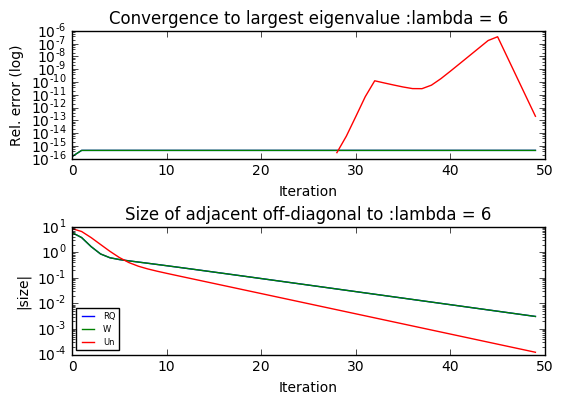

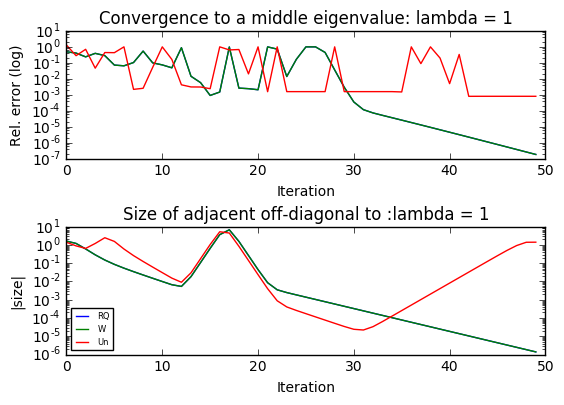

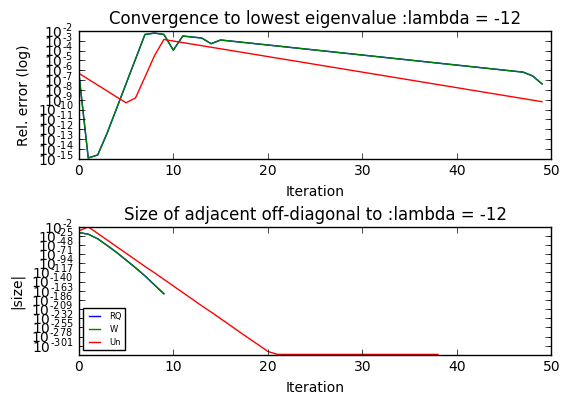

In [7]:
npr.seed(13431)

eigenvalues = -np.sort(-np.array([1,2,3,4,5,6,6,6,0,-10,-12,-12,-1]))
n_eigs = len(eigenvalues)

Delta = np.diag(eigenvalues) 
Q = randOrtho(n_eigs)
A = np.dot(np.dot(Q,Delta),np.transpose(Q)) # Matrix mult
A = sym2tri(A)

n= 50
toprq = np.zeros(n)
topn = np.zeros(n)
topw = np.zeros(n)

lowrq = np.zeros(n)
lown = np.zeros(n)
loww = np.zeros(n)

midrq = np.zeros(n)
midn = np.zeros(n)
midw = np.zeros(n)

offdiaghighrq = np.zeros(n)
offdiaglowrq = np.zeros(n)
offdiagmidrq = np.zeros(n)

offdiaghighn = np.zeros(n)
offdiaglown = np.zeros(n)
offdiagmidn = np.zeros(n)

offdiaghighw = np.zeros(n)
offdiagloww = np.zeros(n)
offdiagmidw = np.zeros(n)


Aq = A
An = A
Aw = A


mid_idx = int(np.ceil(n_eigs/2)) #get the idx of a middle(ish) eigenvalue
for i in range(n):
    # Get RQ shifted values
    eigsq,Aq = eig_qr(Aq,1,'rq')
    toprq[i] = eigsq[0]
    lowrq[i] = eigsq[-1]
    midrq[i] = eigsq[mid_idx]

    # off-diags
    offdiaghighrq[i] = Aq[0+1,0]
    offdiaglowrq[i] = Aq[-2,-1]
    offdiagmidrq[i] = Aq[mid_idx-1,mid_idx]

    # Wilkinson shifted values
    eigsw,Aw = eig_qr(Aw,1,'w')
    topw[i] = eigsw[0]
    loww[i] = eigsw[-1]
    midw[i] = eigsw[mid_idx]

    # off-diags
    offdiaghighw[i] = Aw[0+1,0]
    offdiagloww[i] = Aw[-2,-1]
    offdiagmidw[i] = Aw[mid_idx-1,mid_idx]

    # Non-shifted values
    eigsn,An = eig_qr(An,1)
    topn[i] = eigsn[0]
    lown[i] = eigsn[-1]
    midn[i] = eigsn[mid_idx]

    # off-diags
    offdiaghighn[i] = An[0+1,0]
    offdiaglown[i] = An[-2,-1]
    offdiagmidn[i] = An[mid_idx-1,mid_idx]

############### Plots for highest eigenvalue #####################

high_val = eigenvalues[0]
plt.subplot(2,1,1)
plt.semilogy([abs(e -high_val)/high_val for e in toprq[:]])    
plt.semilogy([abs(e - high_val)/high_val for e in topw[:]])
plt.semilogy([abs(e - high_val)/high_val for e in topn[:]])
plt.xlabel("Iteration")
plt.ylabel("Rel. error (log)")
plt.title('Convergence to largest eigenvalue :lambda = ' + str(high_val))

plt.tight_layout(2)
plt.subplot(2,1,2)
plt.semilogy([abs(e) for e in offdiaghighrq])    
plt.semilogy([abs(e) for e in offdiaghighw]) 
plt.semilogy([abs(e) for e in offdiaghighn]) 
plt.legend(['RQ','W','Un'],loc="lower left", prop={'size': 6})
plt.xlabel("Iteration")
plt.ylabel("|size|")
plt.title('Size of adjacent off-diagonal to :lambda = ' + str(high_val))
plt.show()

############### Plots for a middle eigenvalue #####################

mid_val = eigenvalues[mid_idx]
plt.figure()
plt.subplot(2,1,1)
plt.semilogy([abs(e -mid_val)/abs(mid_val) for e in midrq[:]])    
plt.plot([abs(e - mid_val)/abs(mid_val) for e in midw[:]])
plt.plot([abs(e - mid_val)/abs(mid_val) for e in midn[:]])
plt.xlabel("Iteration")
plt.ylabel("Rel. error (log)")
plt.title('Convergence to a middle eigenvalue: lambda = ' + str(mid_val))

plt.tight_layout(2)
plt.subplot(2,1,2)
plt.semilogy([abs(e) for e in offdiagmidrq])    
plt.semilogy([abs(e) for e in offdiagmidw]) 
plt.semilogy([abs(e) for e in offdiagmidn]) 
plt.legend(['RQ','W','Un'],loc="lower left", prop={'size': 6})
plt.xlabel("Iteration")
plt.ylabel("|size|")
plt.title('Size of adjacent off-diagonal to :lambda = ' + str(mid_val))
plt.show()


############### Plots for lowest eigenvalue #####################
low_val = eigenvalues[-1]
plt.figure()
plt.subplot(2,1,1)
plt.semilogy([abs(e -low_val)/abs(low_val) for e in lowrq[:]])    
plt.semilogy([abs(e - low_val)/abs(low_val) for e in loww[:]])
plt.semilogy([abs(e - low_val)/abs(low_val) for e in lown[:]])
plt.xlabel("Iteration")
plt.ylabel("Rel. error (log)")
plt.title('Convergence to lowest eigenvalue :lambda = ' + str(low_val))

plt.tight_layout(2)
plt.subplot(2,1,2)
plt.semilogy([abs(e) for e in offdiaglowrq])    
plt.semilogy([abs(e) for e in offdiagloww]) 
plt.semilogy([abs(e) for e in offdiaglown]) 
plt.legend(['RQ','W','Un'],loc="lower left", prop={'size': 6})
plt.xlabel("Iteration")
plt.ylabel("|size|")
plt.title('Size of adjacent off-diagonal to :lambda = ' + str(low_val))
plt.show()

Now, the matrix is singular. Additionally, we have negative eigenvalues. We also have eigenvalues equal to $\pm 1$. Here we can see that the unshifted method is not very stable in finding the largest eigenvalue 6. On the other hand shifted methods appear to be stable. 

Both shifted and unshifted seem to struggle with the 1 eigenvalue. Althought ultimately, it seems that the shifted methods have settled down while the unshifted did not. Finally, it really does seem that the unshifted method is good at finding the lowest eigenvalue. It appears to have converged quicker than the shifted methods.

Now let's adapt the method.


### Q7: Shrinking Matricies

In [8]:
npr.seed(13431)

eigenvalues = -np.sort(-np.array([-1,-1,-1,2,40,0,30]))
n_eigs = len(eigenvalues)

Delta = np.diag(eigenvalues) 
Q = randOrtho(n_eigs)
A = np.dot(np.dot(Q,Delta),np.transpose(Q)) # Matrix mult
A = sym2tri(A)

tol = 10**(-10)
def adapted_eigs(A,eigenvalues,tol,shift):
    found_eigs = []
    offdiagonals = np.array([])
    errors = np.array([])
    while A.shape[0] > 1: # while - matrix is a matrix
        n = A.shape[0]
        offdiag = abs(A[n-1,n-2])

        while offdiag > tol:    # Run QR until off diagonal is small
            # Get RQ shifted values
            eigs,A = eig_qr(A,1,shift)
            offdiag = abs(A[n-1,n-2])

            # track errors
            offdiagonals = np.append(offdiagonals,offdiag)
            errors = np.append(errors,abs(eigenvalues[-1] - A[n-1,n-1]))

        found_eigs.append(A[n-1,n-1])
        A = A[:-1,:-1] # remove last row/column
        eigenvalues = eigenvalues[:-1]  
    found_eigs.append(A[0,0])
    
    return found_eigs,errors,offdiagonals            

In [9]:
# Let's check we actually can find eigenvalues
eigs,errors,offdiagonals = adapted_eigs(A,eigenvalues,tol,'rq')
print("RQ found: ")    
print(eigs)
print("Wilkinson found: ")    
eigs,errors,offdiagonals = adapted_eigs(A,eigenvalues,tol,'w')
print(eigs)
print("Unshifted found: ")    
eigs,errors,offdiagonals = adapted_eigs(A,eigenvalues,tol,'None')
print(eigs)

RQ found: 
[-1.0000000000000018, -1.0000000000000022, 2.1679708078272335e-16, -1.0000000000000042, 1.9999999999999998, 29.999999999999989, 39.999999999999964]
Wilkinson found: 
[-1.0000000000000018, -1.0000000000000022, -2.285866638931499e-17, -1.000000000000004, 1.9999999999999984, 29.999999999999954, 39.999999999999957]
Unshifted found: 
[-1.0000000000000018, -1.0000000000000022, -1.0385905123931551e-17, -1.0000000000000047, 1.9999999999999942, 29.999999999999979, 40.000000000000085]


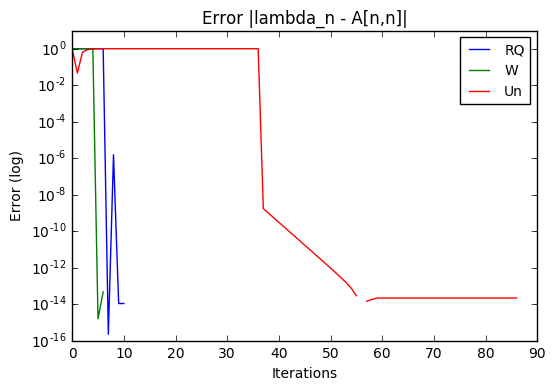

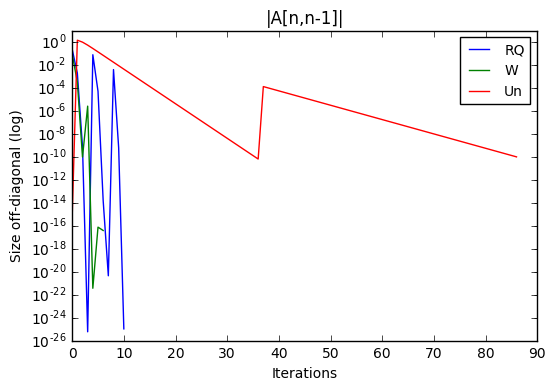

In [10]:
# Ok, now let's plot the errors and off diagonals
eigs,errorsrq,offdiagonalsrq = adapted_eigs(A,eigenvalues,tol,'rq')
eigs,errorsw,offdiagonalsw = adapted_eigs(A,eigenvalues,tol,'w')
eigs,errorsn,offdiagonalsn = adapted_eigs(A,eigenvalues,tol,'None')


# Plot of all errors all methods
plt.semilogy(errorsrq)
plt.semilogy(errorsw)
plt.semilogy(errorsn)
plt.title("Error |lambda_n - A[n,n]|")
plt.xlabel('Iterations')
plt.ylabel('Error (log)')
plt.legend(['RQ','W','Un'],loc="upper right", prop={'size': 10})
plt.show()

# Plot of size of off-diagonals
plt.semilogy(offdiagonalsrq)
plt.semilogy(offdiagonalsw)
plt.semilogy(offdiagonalsn)
plt.title("|A[n,n-1]|")
plt.xlabel('Iterations')
plt.ylabel('Size off-diagonal (log)')
plt.legend(['RQ','W','Un'],loc="upper right", prop={'size': 10})
plt.show()




Now we can really see the power of the shift. Let's focus only on the shifted methods now.

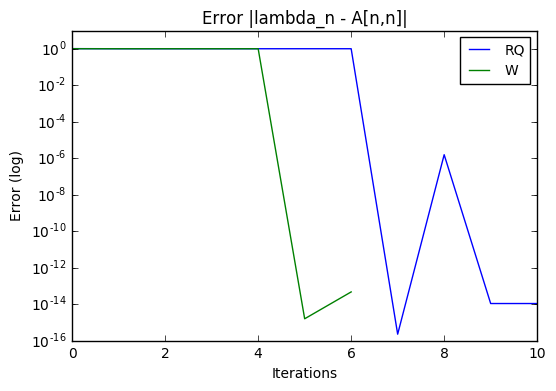

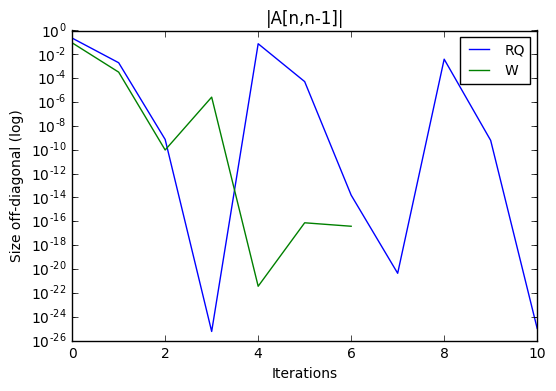

In [11]:
# Plot of all errors on only SHIFTED methods
plt.semilogy(errorsrq)
plt.semilogy(errorsw)
plt.title("Error |lambda_n - A[n,n]|")
plt.xlabel('Iterations')
plt.ylabel('Error (log)')
plt.legend(['RQ','W'],loc="upper right", prop={'size': 10})
plt.show()

# Plot of size of off-diagonals on only SHIFTED methods
plt.semilogy(offdiagonalsrq)
plt.semilogy(offdiagonalsw)
plt.title("|A[n,n-1]|")
plt.xlabel('Iterations')
plt.ylabel('Size off-diagonal (log)')
plt.legend(['RQ','W'],loc="upper right", prop={'size': 10})
plt.show()

Here we really can see that the Wilkinson shift does better than the rest. It really beats the RQ shift by a fair bit and isn't even in the same league as the unshifted method.

We can test out how the methods work for some more interesting eigenvalues.

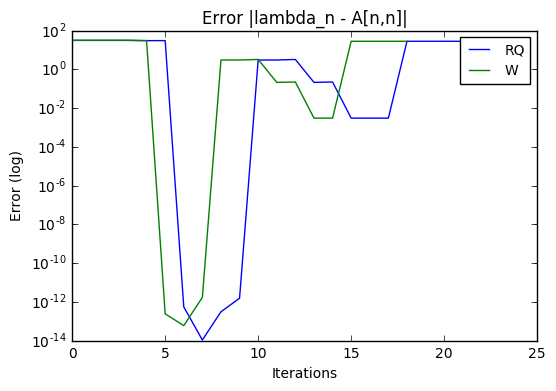

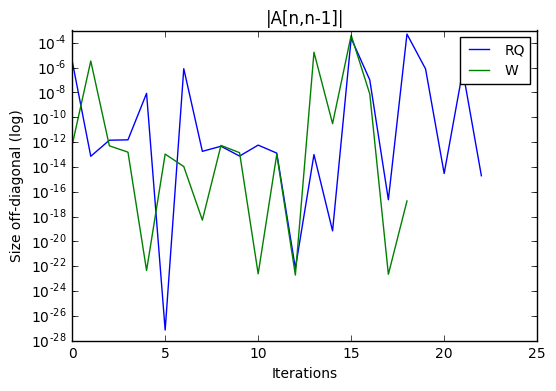

In [12]:
# Now just play around
npr.seed() # I unset the seed to explore better
eigenvalues = -np.sort(-np.array([-1,-1,-1,2,40,0,30,30,30,30,100000,-1000,0,0,0,2,2.2,2.21,2.22,2.223]))
n_eigs = len(eigenvalues)

Delta = np.diag(eigenvalues) 
Q = randOrtho(n_eigs)
A = np.dot(np.dot(Q,Delta),np.transpose(Q)) # Matrix mult
A = sym2tri(A)

tol = 10**(-10)


# Ok, now let's plot the errors and off diagonals
eigs,errorsrq,offdiagonalsrq = adapted_eigs(A,eigenvalues,tol,'rq')
eigs,errorsw,offdiagonalsw = adapted_eigs(A,eigenvalues,tol,'w')
eigs,errorsn,offdiagonalsn = adapted_eigs(A,eigenvalues,tol,'None')



# Plot of all errors on only SHIFTED methods
plt.semilogy(errorsrq)
plt.semilogy(errorsw)
plt.title("Error |lambda_n - A[n,n]|")
plt.xlabel('Iterations')
plt.ylabel('Error (log)')
plt.legend(['RQ','W'],loc="upper right", prop={'size': 10})
plt.show()

# Plot of size of off-diagonals on only SHIFTED methods
plt.semilogy(offdiagonalsrq)
plt.semilogy(offdiagonalsw)
plt.title("|A[n,n-1]|")
plt.xlabel('Iterations')
plt.ylabel('Size off-diagonal (log)')
plt.legend(['RQ','W'],loc="upper right", prop={'size': 10})
plt.show()

After playing with some different eigenvalues, I found the these methods can really handle whatever I gave them. Regarless of the values I gave, the methods performed pretty well. The Wilkinson method always outperformed the RQ. This is interesting because the RQ method has a better on paper convergence rate. However, in practice it seems that Wilkinson always outperforms. 